In [1]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve

In [2]:
raw_data = pd.read_csv("spam.csv", encoding="latin-1", delimiter=",")

raw_data = raw_data.iloc[:, :2]
raw_data = raw_data.drop_duplicates()
raw_data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Naive Bayes (Baseline)

In [3]:
from nltk.corpus import stopwords
import re

sw = stopwords.words('english')
unique_words = list()


def clean_text(text):
    global unique_words
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    text = re.sub(r"\s+", " ", text)
        
    text = [word.lower() for word in text.split() if word.lower() not in sw] #removing stopwords
    for word in text:
        if word in unique_words:
            continue
        unique_words.append(word)
    
    text = " ".join(text)
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

raw_data["v2"] = raw_data["v2"].apply(lambda x: clean_text(x))

X_train, X_test, y_train, y_test = train_test_split(raw_data["v2"], raw_data["v1"], test_size=0.2, stratify=raw_data["v1"])

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       903
           1       1.00      0.76      0.87       131

    accuracy                           0.97      1034
   macro avg       0.98      0.88      0.92      1034
weighted avg       0.97      0.97      0.97      1034



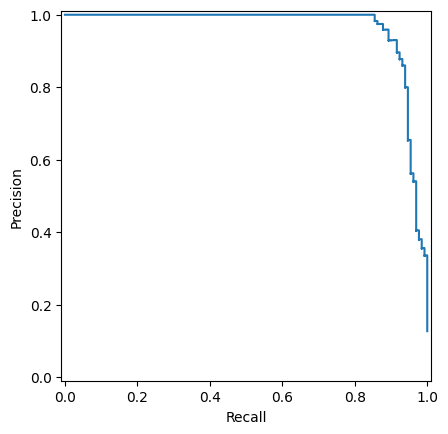

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
import numpy as np
from sklearn.metrics import classification_report

vectorizer = TfidfVectorizer()
NB_X_train = vectorizer.fit_transform(X_train)
NB_y_train = np.array(y_train.apply(lambda x: 0 if x == "ham" else 1))

NB_X_test = vectorizer.transform(X_test)
NB_y_test = np.array(y_test.apply(lambda x: 0 if x == "ham" else 1))

model = MultinomialNB(class_prior=[0.87, 0.13])
model.fit(NB_X_train, NB_y_train)

y_proba = model.predict_proba(NB_X_test)
predict = (y_proba[:, 1] > 0.5).astype(int) 

prec, recall, _ = precision_recall_curve(NB_y_test, y_proba[:, 1], pos_label=1)

print(classification_report(NB_y_test, predict))
PrecisionRecallDisplay(prec, recall).plot();

# Neural network

In [5]:
from torch.utils.data import DataLoader, Dataset

X_train, X_test, y_train, y_test = train_test_split(raw_data["v2"], raw_data["v1"], test_size=0.1, stratify=raw_data["v1"])

In [6]:
from nltk.tokenize import TweetTokenizer
from collections import Counter

tokenizer = TweetTokenizer()

pad = 0
unk = 1
token_to_indx = {
    "<PAD>": 0,
    "<UNK>": 1
}
tokens_count = Counter()

def text_to_tokens(text):
    res = list()
    for sentence in text:
        tokens = tokenizer.tokenize(sentence)
        res.append([token for token in tokens if token.lower() not in sw])
    return res

tokenized_X_train = text_to_tokens(X_train)
tokenized_X_test = text_to_tokens(X_test)
for sentence in tokenized_X_train:
    tokens_count.update(sentence)

In [7]:
print("Tokens in total:", len(tokens_count))

min_amount = 1 # Token must appear once at least min_amount times to not be UNK
unique_tokens = [token for token in tokens_count if tokens_count[token] >= min_amount]
unique_tokens.append("<PAD>")
unique_tokens.append("<UNK>")

print("Tokens left:", len(unique_tokens))
for ind, token in enumerate(unique_tokens):
    token_to_indx[token] = ind + 2

Tokens in total: 7127
Tokens left: 7129


In [8]:
import plotly.express as px

data_lens = np.array([len(sentence) for sentence in tokenized_X_train])

max_len = int(np.percentile(data_lens, 95))
print(max_len)
px.histogram(data_lens)

21


In [9]:
def data_to_vector(data):
    res = list()
    for sentence in data:
        line = [token_to_indx.get(token, unk) for token in sentence]
        line = line[:max_len]
        line = line + [pad] * (max_len - len(line))
        res.append(line)
    return np.array(res)


numerated_X_train = data_to_vector(tokenized_X_train)
numerated_X_test = data_to_vector(tokenized_X_test)

numerated_X_train

array([[   2,    3,    4, ...,    0,    0,    0],
       [   7,    8,    9, ...,    0,    0,    0],
       [  15,   16,   17, ...,    0,    0,    0],
       ...,
       [1476,  336, 1123, ...,    0,    0,    0],
       [2419, 1437, 2377, ...,    0,    0,    0],
       [2490,  871, 7128, ...,    0,    0,    0]])

In [10]:
import torch

device = torch.device("cuda")

# device = torch.device('cpu')

In [ ]:
class SpamDataset(Dataset):
    def __init__(self, x, y):
        self.texts = torch.tensor(x).to(device)
        self.y = torch.tensor(y).float().to(device)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        return self.texts[index], self.y[index]

y_train = np.array(y_train.apply(lambda x: x == "spam"))
train_data = SpamDataset(numerated_X_train, y_train)

y_test = torch.tensor(np.array(y_test.apply(lambda x: x == "spam"))).to(device).float()
numerated_X_test = torch.tensor(numerated_X_test).to(device)


batch_size=64
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [12]:
from torch import nn

class SpamDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedder = nn.Embedding(len(unique_tokens), 128)
        self.core_stack = nn.LSTM(128, 128, batch_first=True)
        self.linear_stack = nn.Sequential(
            nn.Linear(128, 64),
            nn.Linear(64, 1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded_x = self.embedder(x)
        _, (last_states, _) = self.core_stack(embedded_x)
        stacked_x = last_states[-1]
        verdict = self.linear_stack(stacked_x)

        verdict = torch.squeeze(verdict)

        return verdict.float().to(device)

In [ ]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

threshold = 0.5
determine = lambda x: x > threshold

def train_loop(model: torch.nn.Module, optimizer, criterion):
    train_logs, test_logs, f1_logs = [], [], []
    for epoch in range(20):
        model.train()
        for (X, y) in train_dataloader:
            pred = model(X)

            optimizer.zero_grad()
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

        print(f"Epoch: {epoch} | train_loss: {loss:>7f} | ", end="")
        train_logs.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_loss = 0
            pred = model(numerated_X_test)
            val_loss += criterion(pred, y_test).item()
            print(f"test_Loss: {val_loss / len(numerated_X_test)}")
            label_pred = determine(pred)

            TP = ((label_pred == 1) & (y_test == 1)).sum().item()
            FP = ((label_pred == 1) & (y_test == 0)).sum().item()
            FN = ((label_pred == 0) & (y_test == 1)).sum().item()

            prec = TP / (FP + TP)
            recall = TP / (FN + TP)
            f1 = 2 / ((1 / (prec)) + (1 / (recall))) 

            print(f"Precision: {prec:>5f} | Recall: {recall:>5f} | F1-score: {f1:>5f}", end="\n\n")

            test_logs.append(val_loss / len(numerated_X_test))
            f1_logs.append(f1)
            
    return train_logs, test_logs, f1_logs

model = SpamDetector().to(device)
optimizer = Adam(model.parameters(), weight_decay=1e-5)
loss = BCEWithLogitsLoss(pos_weight=torch.tensor([8.0])).to(device)

train_logs, test_logs, f1_logs = train_loop(model, optimizer, loss)

Epoch: 0 | train_loss: 0.739503 | test_Loss: 0.0007960690289908728
Precision: 0.771429 | Recall: 0.830769 | F1-score: 0.800000

Epoch: 1 | train_loss: 0.356788 | test_Loss: 0.0003897075035124729
Precision: 0.768293 | Recall: 0.969231 | F1-score: 0.857143

Epoch: 2 | train_loss: 0.044766 | test_Loss: 0.0004891033214111623
Precision: 0.855072 | Recall: 0.907692 | F1-score: 0.880597

Epoch: 3 | train_loss: 0.030440 | test_Loss: 0.0004031333632810434
Precision: 0.845070 | Recall: 0.923077 | F1-score: 0.882353

Epoch: 4 | train_loss: 0.014642 | test_Loss: 0.000532059939271938
Precision: 0.907692 | Recall: 0.907692 | F1-score: 0.907692

Epoch: 5 | train_loss: 0.035541 | test_Loss: 0.0006830833520833944
Precision: 0.880597 | Recall: 0.907692 | F1-score: 0.893939

Epoch: 6 | train_loss: 0.007867 | test_Loss: 0.0007362322489113134
Precision: 0.935484 | Recall: 0.892308 | F1-score: 0.913386

Epoch: 7 | train_loss: 0.001132 | test_Loss: 0.0007637431358691572
Precision: 0.906250 | Recall: 0.892308

In [14]:
import plotly.express as px
import plotly.graph_objects as go 

figure = go.Figure()
figure.add_trace(go.Scatter(y=train_logs, name="Train BCE"))
figure.add_trace(go.Scatter(y=test_logs, name="Test BCE"))
figure.add_trace(go.Scatter(y=f1_logs, name="f1-score"))

figure.show()

In [15]:
with torch.no_grad():
    print(classification_report(y_test.cpu(), determine(model(numerated_X_test).cpu())))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       452
         1.0       0.85      0.92      0.88        65

    accuracy                           0.97       517
   macro avg       0.92      0.95      0.93       517
weighted avg       0.97      0.97      0.97       517

